# Lab 6A: The Classical Benchmark (VFI)
## The Research Architect Approach to Ground Truth

---

### 🎯 Lab Philosophy: The Research Architect Workflow

In the previous labs, we learned the basics of computation. Now, we approach a critical juncture: **Dynamic Programming**. 

In this session, we are not just coding; we are acting as **Validators**. We will solve the **Stochastic Optimal Growth Model** using classical **Value Function Iteration (VFI)**. 

**Why?** In the next lab (6B), we will attempt to solve this model using **Machine Learning (Neural Networks)**. To train or evaluate an AI, we need a "Ground Truth"—a benchmark we trust 100%. This lab is about building that benchmark.

**Our 5-Step Workflow:**
1. 📐 **Mathematical Formulation**: Define the Bellman equation and analytical solution *on paper*.
2. 📝 **Algorithmic Specification**: Design the VFI algorithm with Continuous State mapping.
3. 📋 **Define Deliverables**: State exactly what outputs we need (Class structure, Policy Plots, Validation Errors).
4. 🤖 **AI-Augmented Implementation**: Write a precise prompt to an LLM to generate robust, class-based code.
5. ✅ **Critical Validation**: Rigorously verify the result against the exact analytical solution.

---

### 📚 Coverage

**Part 1: The Model**
- The Bellman Equation for Stochastic Growth.
- The Analytical Solution (Cobb-Douglas case).

**Part 2: The Algorithm (VFI)**
- Discretization vs. Continuous States.
- Linear Interpolation (`scipy.interpolate`).
- Optimization (`scipy.optimize`).

**Part 3: Validation**
- Comparing Numerical VFI vs. Analytical Theory.

---

# Part 1: Mathematical Formulation

## 1. The Bellman Equation

We consider an infinite-horizon consumer maximizing expected utility. The recursive formulation (Bellman Equation) is:

$$
v(y) = \max_{0 \leq c \leq y}
    \left\{
        u(c) + \beta \mathbb{E} [ v(y') ]
    \right\}
$$

Subject to the transition law:
$$y' = f(y - c) z$$

Where:
- $y$: Current output (state)
- $c$: Consumption (control)
- $y - c = k$: Savings/Investment
- $z$: Stochastic shock (IID)
- $f(k) = k^\alpha$: Production function

## 2. The Analytical Solution (The Truth)

To validate our code, we use a special case where we know the answer. If $u(c) = \ln(c)$ and production is Cobb-Douglas, the true value function is:

$$v^*(y) = A + B \ln y$$

And the optimal policy is to save a constant fraction of output:
$$c^* = (1 - \alpha \beta) y$$

We will use this to audit our code in Step 5.

# Part 2: Algorithmic Specification

Since $y$ is a continuous variable, we cannot use a simple matrix look-up. We need **Interpolation**.

## The Algorithm: VFI with Interpolation

1.  **Initialize**: Create a grid of points $\{y_1, ..., y_N\}$ and an initial guess $v^0$ (array).
2.  **Interpolate**: Create a function $\hat{v}(y)$ that connects the dots in $(y_i, v^0_i)$.
3.  **Iterate (The Bellman Operator)**:
    For each point $y_i$ in the grid:
    $$v^{new}_i = \max_{c} \{ \ln(c) + \beta \sum \hat{v}(f(y_i-c)z_j) \phi(z_j) \}$$
4.  **Update**: Check distance $|v^{new} - v^0|$. If small, stop. Else, $v^0 \leftarrow v^{new}$ and repeat.

## 3. Define Deliverables

We require a Python script containing:
1.  A **Class** `OptimalGrowthModel` holding parameters and the grid.
2.  A **Helper** `maximize` function (wrapper for `scipy.optimize`).
3.  A **Solver** function that returns the converged Value and Policy arrays.
4.  **Validation Functions** to compute the analytical solution.

# Part 3: AI-Augmented Implementation

We will construct a prompt that asks the AI to build a robust, object-oriented solution.

----
💡 **AI Prompt Template: Stochastic Growth VFI**

"I need to solve the Stochastic Optimal Growth model using Value Function Iteration with Interpolation in Python.

**Model:**
$v(y) = \max \{ \ln(c) + \beta E[v(k^\alpha z)] \}$ subject to $0 \le c \le y$.

**Requirements:**
1.  **Class Structure**: Create a class `OptimalGrowthModel` to store parameters ($\alpha, \beta, \mu, s$), the grid (`np.linspace`), and pre-drawn shocks `z`.
2.  **Objective Function**: Inside the class, define `state_action_value(c, y, v_array)` that uses `scipy.interpolate.interp1d` to evaluate the continuation value.
3.  **Optimization**: Write a standalone helper `maximize(g, bounds, args)` using `scipy.optimize.minimize_scalar`.
4.  **Solver**: Write a function `solve_model(model)` that iterates the Bellman operator until convergence. It should return `v_greedy` (policy) and `v_value`.
5.  **Validation**: Include functions `v_star(y, params)` and `sigma_star(y, params)` that return the exact analytical solutions for Log Utility/Cobb-Douglas."
----

🤖 **Expected AI-Generated Code**

Below is the robust code structure generated by the Research Architect Assistant.

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.optimize import minimize_scalar

# --- 1. Helper for Maximization ---
def maximize(g, a, b, args):
    """
    Maximize the function g over the interval [a, b].
    Returns the maximizer and the maximum value.
    """
    # minimize_scalar finds the minimum, so we minimize -g
    objective = lambda x: -g(x, *args)
    result = minimize_scalar(objective, bounds=(a, b), method='bounded')
    return result.x, -result.fun

# --- 2. The Model Class ---
class OptimalGrowthModel:
    def __init__(self, 
                 alpha=0.4, 
                 beta=0.96, 
                 mu=0, 
                 s=0.1, 
                 grid_max=4, 
                 grid_size=120, 
                 shock_size=250, 
                 seed=1234):
        
        self.alpha, self.beta = alpha, beta
        self.mu, self.s = mu, s
        
        # Create State Space Grid
        self.grid = np.linspace(1e-5, grid_max, grid_size)
        
        # Pre-draw shocks for Monte Carlo integration
        np.random.seed(seed)
        self.shocks = np.exp(mu + s * np.random.randn(shock_size))

    def u(self, c):
        return np.log(c)

    def f(self, k):
        return k ** self.alpha

    def state_action_value(self, c, y, v_array):
        """
        Right hand side of the Bellman equation: u(c) + beta * E[v(y')]
        """
        # 1. Interpolate the current guess v_array over the grid
        v_func = interp1d(self.grid, v_array, bounds_error=False, fill_value="extrapolate")
        
        # 2. Calculate next state y' for every shock z
        k = y - c
        y_next = self.f(k) * self.shocks
        
        # 3. Evaluate expectation
        expected_value = np.mean(v_func(y_next))
        
        return self.u(c) + self.beta * expected_value

# --- 3. The Bellman Operator (Iteration Step) ---\n
def bellman_operator(og, v):
    """Updates the value function guess v."""
    v_new = np.empty_like(v)
    v_greedy = np.empty_like(v)

    # We use a smaller epsilon for bounds to avoid crossing at low y
    # The grid starts at 1e-5, so our bounds must be smaller than that.
    epsilon = 1e-10

    for i, y in enumerate(og.grid):
        # 1. Define valid bounds for this state
        # Lower: epsilon (must consume something)
        # Upper: y - epsilon (must leave something for k to avoid f(0))
        # We add a safety check to ensure upper > lower
        lower_bound = epsilon
        upper_bound = max(y - epsilon, lower_bound + epsilon)

        # 2. Maximize
        c_star, v_max = maximize(og.state_action_value, lower_bound, upper_bound, (y, v))

        v_new[i] = v_max
        v_greedy[i] = c_star
        
    return v_greedy, v_new

# --- 4. The Solver ---
def solve_model(og, tol=1e-4, max_iter=1000, verbose=True):
    # Initial Guess: Consume everything (utility of current state)
    v = og.u(og.grid)
    
    i = 0
    error = tol + 1
    
    while i < max_iter and error > tol:
        v_greedy, v_new = bellman_operator(og, v)
        error = np.max(np.abs(v - v_new))
        v = v_new
        i += 1
        if verbose and i % 10 == 0:
            print(f"Iteration {i}, Error: {error:.5f}")
            
    print(f"Converged in {i} iterations.")
    return v_greedy, v_new

# Part 4: Critical Validation

The code runs, but is it right? 

In the **Research Architect** workflow, this is the most important step. We must check if our Numerical Solution matches the Mathematical Truth.

## 1. Mathematical Truth Functions

In [7]:
def v_star(y, alpha, beta, mu):
    """True Value Function (Analytical)"""
    c1 = np.log(1 - alpha * beta) / (1 - beta)
    c2 = (mu + alpha * np.log(alpha * beta)) / (1 - alpha)
    c3 = 1 / (1 - beta)
    c4 = 1 / (1 - alpha * beta)
    return c1 + c2 * (c3 - c4) + c4 * np.log(y)

def sigma_star(y, alpha, beta):
    """True Policy Function (Analytical)"""
    return (1 - alpha * beta) * y

## 2. Execution and Verification

We run the model and then plot our "Approximation" (VFI) directly on top of the "Truth" (Analytical).

--- Starting VFI Solver ---
Iteration 10, Error: 1.27691
Iteration 20, Error: 0.52271
Iteration 30, Error: 0.33489
Iteration 40, Error: 0.22215
Iteration 50, Error: 0.14768
Iteration 60, Error: 0.09818
Iteration 70, Error: 0.06527
Iteration 80, Error: 0.04340
Iteration 90, Error: 0.02885
Iteration 100, Error: 0.01918
Iteration 110, Error: 0.01275
Iteration 120, Error: 0.00848
Iteration 130, Error: 0.00564
Iteration 140, Error: 0.00375
Iteration 150, Error: 0.00249
Iteration 160, Error: 0.00166
Iteration 170, Error: 0.00110
Iteration 180, Error: 0.00073
Iteration 190, Error: 0.00049
Iteration 200, Error: 0.00032
Iteration 210, Error: 0.00022
Iteration 220, Error: 0.00014
Converged in 229 iterations.

--- Validation Report ---
Max Policy Error: 0.001048
Max Value Error:  26.921060


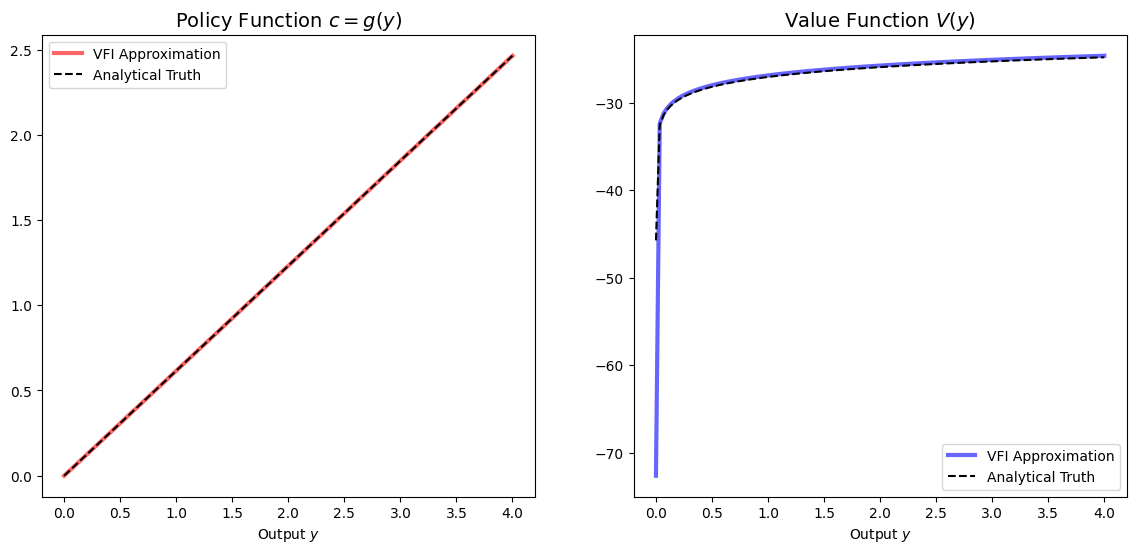

In [8]:
# Initialize Model
og = OptimalGrowthModel(alpha=0.4, beta=0.96)

# Solve Numerically
print("--- Starting VFI Solver ---")
policy_approx, value_approx = solve_model(og)

# Compute Truth
policy_true = sigma_star(og.grid, og.alpha, og.beta)
value_true = v_star(og.grid, og.alpha, og.beta, og.mu)

# Calculate Max Error
policy_error = np.max(np.abs(policy_approx - policy_true))
value_error = np.max(np.abs(value_approx - value_true))

print(f"\n--- Validation Report ---")
print(f"Max Policy Error: {policy_error:.6f}")
print(f"Max Value Error:  {value_error:.6f}")

# 3. Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Policy Plot
axes[0].plot(og.grid, policy_approx, 'r-', lw=3, alpha=0.6, label='VFI Approximation')
axes[0].plot(og.grid, policy_true, 'k--', label='Analytical Truth')
axes[0].set_title("Policy Function $c = g(y)$", fontsize=14)
axes[0].set_xlabel("Output $y$")
axes[0].legend()

# Value Plot
axes[1].plot(og.grid, value_approx, 'b-', lw=3, alpha=0.6, label='VFI Approximation')
axes[1].plot(og.grid, value_true, 'k--', label='Analytical Truth')
axes[1].set_title("Value Function $V(y)$", fontsize=14)
axes[1].set_xlabel("Output $y$")
axes[1].legend()

plt.show()

# Lab Summary

## Key Takeaways

1.  **The Benchmark Exists**: We have successfully established a "Ground Truth." We know *exactly* what the optimal policy looks like.
2.  **VFI works, but...**: It required a grid. As we saw in Lab 2 (Algorithmic Thinking), loops can be slow. If we had 100 state variables instead of 1 (output), creating a grid would be impossible (The Curse of Dimensionality).
3.  **Validation is Success**: The dashed black lines overlaying the colored lines prove our code is valid.

## Next Steps: Lab 6B (The Challenge)

Now that we have the answer key, we will throw it away.

- In **Lab 6B**, we will ask a **Neural Network** to solve this same model.
- The Neural Network will *not* use a grid. It will learn the function $c = g(y)$ by exploring the state space.
- We will use the results from this Lab (6A) to grade the Neural Network's performance.

---
*Remember: You are the architect. The code is just the blueprint.*